<a name='0_0'></a>
# <span style="color:#ff5f27">👨🏻‍🏫 LSTM </span>

🗄️ Table of Contents:

- [📝 Imports](#0)
- [💾 Spam Dataset](#1)
    - [👨🏻‍🍳 Data Preparation](#11)
    - [👩🏻‍🔬 Model Experiments](#12)
    - [📝 Results](#13)
- [💾 IMDB Dataset](#2)
    - [👩🏻‍🔬 Model Experiments](#22)
    - [👮🏻‍♂️ Final Model Validation](#23)
    - [👩🏻‍🔬 LSTM+CNN Architecture](#24)
    - [📝 Results](#25)

<a name='0'></a>
## <span style="color:#ff5f27">📝 Imports </span>
- [🗄️ Table of Contents](#0_0)

In [1]:
import os
import random
from tensorflow.random import set_seed
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder 

from keras.models import Model 
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, MaxPooling1D
from keras.layers.convolutional import Conv1D 
from keras.optimizers import RMSprop 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing import sequence 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical 
from keras.callbacks import EarlyStopping 
from tensorflow.keras.optimizers import Adam

%matplotlib inline 

2023-10-31 23:25:04.120821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


---
<a name='1'></a>
## <span style="color:#ff5f27">💾 Spam Dataset </span>
- [🗄️ Table of Contents](#0_0)

In [2]:
df = pd.read_csv('data/spam.csv', delimiter=',', encoding='latin-1') 
df.head(3) 

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN


In [3]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True) 
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   object
 1   v2      5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


Text(0.5, 1.0, 'Number of ham and spam messages')

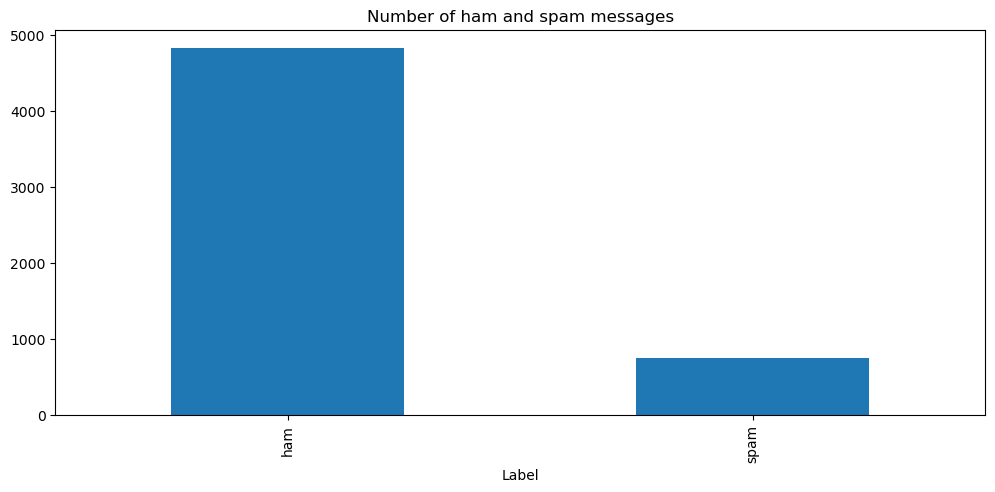

In [4]:
plt.figure(figsize=(12,5))
df.v1.value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [5]:
X = df.v2 
Y = df.v1 

In [6]:
le = LabelEncoder() 
Y = le.fit_transform(Y) 
Y = Y.reshape(-1,1) 
Y[:3]

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


array([[0],
       [0],
       [1]])

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.15,
    random_state=46,
) 

<a name='11'></a>
## <span style="color:#ff5f27">👨🏻‍🍳 Data Preparation </span>
- [🗄️ Table of Contents](#0_0)

In [8]:
max_words = 1000 
max_len = 150 
tok = Tokenizer(num_words=max_words) 
tok.fit_on_texts(X_train) 

In [9]:
sequences = tok.texts_to_sequences(X_train) 
print(f'⛳️ Amount of sentences: {len(sequences)}')
print(f'⛳️ Len of the first and second sentences: {len(sequences[0])}, {len(sequences[1])}')

⛳️ Amount of sentences: 4736
⛳️ Len of the first and second sentences: 5, 28


In [10]:
sequences_matrix = pad_sequences(
    sequences, 
    maxlen=max_len,
) 
print(f'⛳️ Len of the first and second sentences: {len(sequences_matrix[0])}, {len(sequences_matrix[1])}')

⛳️ Len of the first and second sentences: 150, 150


In [11]:
test_sequences = tok.texts_to_sequences(X_test) 
test_sequences_matrix = pad_sequences(test_sequences,maxlen=max_len)

<a name='12'></a>
## <span style="color:#ff5f27">👩🏻‍🔬 Model Experiments </span>
- [🗄️ Table of Contents](#0_0)

In [12]:
def reset_seeds(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value) 
    random.seed(seed_value)
    set_seed(seed_value)

In [13]:
def plot_loss(history, scores_df, model_name, test_accuracy):
    
    train_loss = history.history["loss"][-1]
    val_loss = history.history["val_loss"][-1]

    new_scores_df = pd.DataFrame(
        {
            'model_name': [model_name], 
            'train_loss': [train_loss], 
            'val_loss': [val_loss],
            'test_accuracy': [test_accuracy],
        }
    )
    scores_df = pd.concat([scores_df, new_scores_df],ignore_index=True)
    
    print(f'🎯 Train Loss: {train_loss}')
    print(f'🎯 Val Loss: {val_loss}')
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))

    ax.plot(history.history['loss'], label="train loss")
    ax.plot(history.history['val_loss'], label="validation loss")
    ax.set_title("Loss")
    ax.set_xlabel("Number of Epochs")
    ax.set_ylabel("Loss")
    ax.legend()

    plt.show()
    
    return scores_df

In [14]:
scores_df_spam = pd.DataFrame(columns=['model_name', 'train_loss', 'val_loss', 'test_accuracy'])
scores_df_spam

,model_name,train_loss,val_loss,test_accuracy


In [15]:
reset_seeds()
inputs = Input(name='inputs',shape=[max_len]) 

layer = Embedding(
    max_words,
    50,
    input_length=max_len,
)(inputs) 
layer = LSTM(64)(layer) 
layer = Dense(256)(layer) 
layer = Activation('relu')(layer) 
layer = Dropout(0.5)(layer) 
layer = Dense(1,name='out_layer')(layer) 
layer = Activation('sigmoid')(layer) 

model_default = Model(
    inputs=inputs,
    outputs=layer,
)

2023-10-31 23:25:11.049265: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model_default.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'],
)

In [17]:
history_default = model_default.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=10, 
    validation_split=0.2,
)

Epoch 1/10
30/30 [==============================] - 5s 100ms/step - loss: 0.3137 - accuracy: 0.8857 - val_loss: 0.1688 - val_accuracy: 0.9789
Epoch 2/10
30/30 [==============================] - 3s 84ms/step - loss: 0.0886 - accuracy: 0.9791 - val_loss: 0.0686 - val_accuracy: 0.9852
Epoch 3/10
30/30 [==============================] - 3s 87ms/step - loss: 0.0424 - accuracy: 0.9886 - val_loss: 0.0720 - val_accuracy: 0.9778
Epoch 4/10
30/30 [==============================] - 2s 83ms/step - loss: 0.0332 - accuracy: 0.9902 - val_loss: 0.0684 - val_accuracy: 0.9789
Epoch 5/10
30/30 [==============================] - 2s 84ms/step - loss: 0.0255 - accuracy: 0.9918 - val_loss: 0.0692 - val_accuracy: 0.9884
Epoch 6/10
30/30 [==============================] - 2s 79ms/step - loss: 0.0200 - accuracy: 0.9926 - val_loss: 0.0827 - val_accuracy: 0.9884
Epoch 7/10
30/30 [==============================] - 3s 91ms/step - loss: 0.0162 - accuracy: 0.9952 - val_loss: 0.0871 - val_accuracy: 0.9884
Epoch 8/10
3

In [18]:
accuracy = model_default.evaluate(test_sequences_matrix,Y_test)[1]

27/27 [==============================] - 0s 11ms/step - loss: 0.1008 - accuracy: 0.9868


🎯 Train Loss: 0.006932410877197981
🎯 Val Loss: 0.09851965308189392


/var/folders/jc/bcd0px_d09v6ph36k1s810sw0000gn/T/ipykernel_23598/3714532847.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, new_scores_df],ignore_index=True)


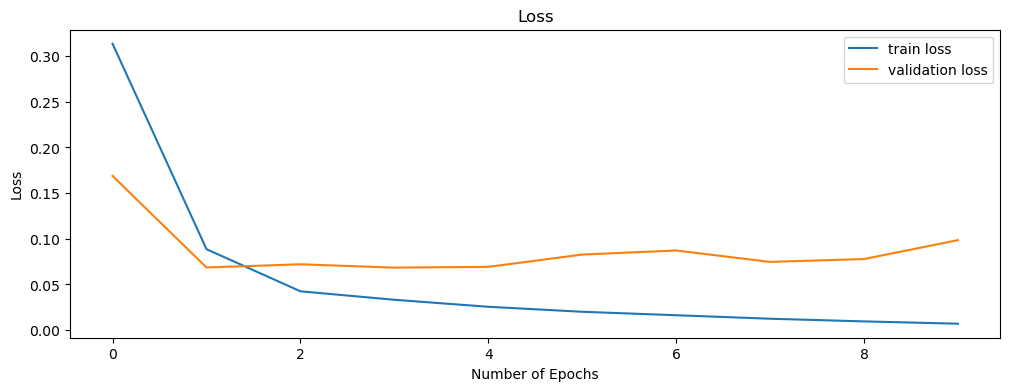

In [19]:
scores_df_spam = plot_loss(
    history_default, 
    scores_df_spam, 
    'LSTM_RMSprop',
    accuracy,
)

In [20]:
reset_seeds()
inputs = Input(name='inputs',shape=[max_len]) 

layer = Embedding(
    max_words,
    25,
    input_length=max_len,
)(inputs) 
layer = LSTM(64)(layer) 
layer = Dense(256)(layer) 
layer = Activation('relu')(layer) 
layer = Dropout(0.5)(layer) 
layer = Dense(1,name='out_layer')(layer) 
layer = Activation('sigmoid')(layer) 

model_embedding25 = Model(
    inputs=inputs,
    outputs=layer,
)

In [21]:
model_embedding25.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'],
)

history_embedding25 = model_embedding25.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=10, 
    validation_split=0.2,
)

Epoch 1/10
30/30 [==============================] - 5s 86ms/step - loss: 0.3714 - accuracy: 0.8648 - val_loss: 0.3017 - val_accuracy: 0.9715
Epoch 2/10
30/30 [==============================] - 3s 90ms/step - loss: 0.1401 - accuracy: 0.9659 - val_loss: 0.0786 - val_accuracy: 0.9821
Epoch 3/10
30/30 [==============================] - 2s 77ms/step - loss: 0.0559 - accuracy: 0.9847 - val_loss: 0.0762 - val_accuracy: 0.9821
Epoch 4/10
30/30 [==============================] - 2s 71ms/step - loss: 0.0392 - accuracy: 0.9897 - val_loss: 0.0725 - val_accuracy: 0.9800
Epoch 5/10
30/30 [==============================] - 2s 71ms/step - loss: 0.0310 - accuracy: 0.9905 - val_loss: 0.0662 - val_accuracy: 0.9884
Epoch 6/10
30/30 [==============================] - 2s 74ms/step - loss: 0.0266 - accuracy: 0.9916 - val_loss: 0.0687 - val_accuracy: 0.9873
Epoch 7/10
30/30 [==============================] - 2s 78ms/step - loss: 0.0226 - accuracy: 0.9931 - val_loss: 0.0747 - val_accuracy: 0.9873
Epoch 8/10
30

In [22]:
accuracy = model_embedding25.evaluate(test_sequences_matrix,Y_test)[1]

27/27 [==============================] - 0s 11ms/step - loss: 0.0796 - accuracy: 0.9868


🎯 Train Loss: 0.009797235950827599
🎯 Val Loss: 0.08675021678209305


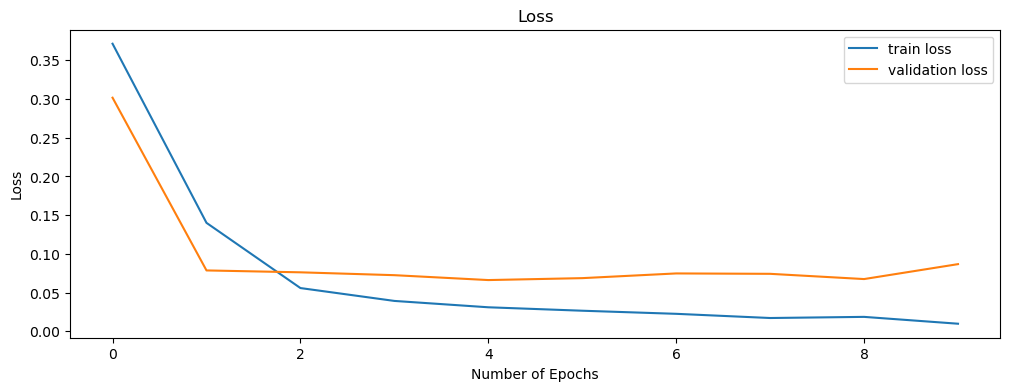

In [23]:
scores_df_spam = plot_loss(
    history_embedding25, 
    scores_df_spam, 
    'Embeddings25',
    accuracy,
)

In [24]:
scores_df_spam

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_RMSprop,0.006932,0.09852,0.986842
1,Embeddings25,0.009797,0.08675,0.986842


In [25]:
reset_seeds()
inputs = Input(name='inputs',shape=[max_len]) 

layer = Embedding(
    max_words,
    25,
    input_length=max_len,
)(inputs) 
layer = LSTM(32)(layer) 
layer = Dense(256)(layer) 
layer = Activation('relu')(layer) 
layer = Dropout(0.5)(layer) 
layer = Dense(1,name='out_layer')(layer) 
layer = Activation('sigmoid')(layer) 

model_lstm32 = Model(
    inputs=inputs,
    outputs=layer,
) 

In [26]:
model_lstm32.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'],
)

history_lstm32 = model_lstm32.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=10, 
    validation_split=0.2,
)

Epoch 1/10
30/30 [==============================] - 3s 51ms/step - loss: 0.3532 - accuracy: 0.8680 - val_loss: 0.2045 - val_accuracy: 0.9578
Epoch 2/10
30/30 [==============================] - 1s 40ms/step - loss: 0.1311 - accuracy: 0.9686 - val_loss: 0.0868 - val_accuracy: 0.9831
Epoch 3/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0552 - accuracy: 0.9860 - val_loss: 0.0785 - val_accuracy: 0.9800
Epoch 4/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0368 - accuracy: 0.9894 - val_loss: 0.0770 - val_accuracy: 0.9768
Epoch 5/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0287 - accuracy: 0.9918 - val_loss: 0.0766 - val_accuracy: 0.9852
Epoch 6/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0240 - accuracy: 0.9923 - val_loss: 0.0821 - val_accuracy: 0.9863
Epoch 7/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0207 - accuracy: 0.9929 - val_loss: 0.0817 - val_accuracy: 0.9873
Epoch 8/10
30

In [27]:
accuracy = model_lstm32.evaluate(test_sequences_matrix,Y_test)[1]

27/27 [==============================] - 0s 8ms/step - loss: 0.0719 - accuracy: 0.9892


🎯 Train Loss: 0.008170493878424168
🎯 Val Loss: 0.09418149292469025


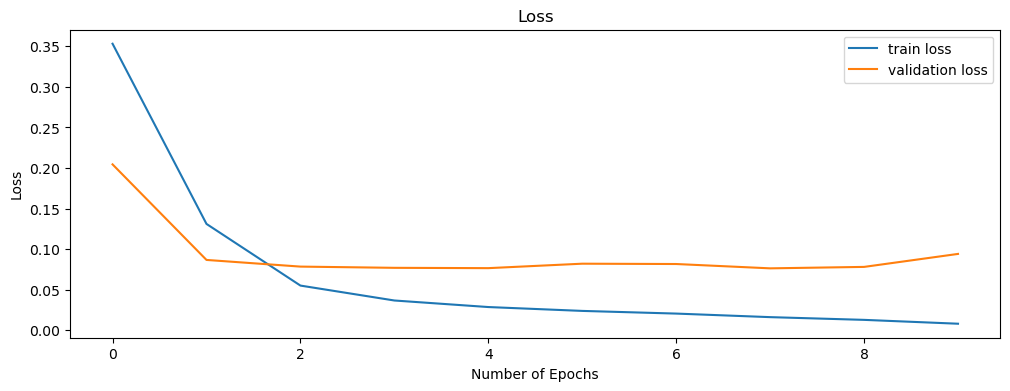

In [28]:
scores_df_spam = plot_loss(
    history_lstm32, 
    scores_df_spam, 
    'Embedding25_LSTM32',
    accuracy,
)

In [29]:
scores_df_spam

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_RMSprop,0.006932,0.098520,0.986842
1,Embeddings25,0.009797,0.086750,0.986842
2,Embedding25_LSTM32,0.008170,0.094181,0.989234


In [30]:
reset_seeds()
inputs = Input(name='inputs',shape=[max_len]) 

layer = Embedding(
    max_words,
    25,
    input_length=max_len,
)(inputs) 
layer = LSTM(32)(layer) 
layer = Dense(128)(layer) 
layer = Activation('relu')(layer) 
layer = Dropout(0.5)(layer) 
layer = Dense(1,name='out_layer')(layer) 
layer = Activation('sigmoid')(layer) 

model_dense_simpler = Model(
    inputs=inputs,
    outputs=layer,
)

In [31]:
model_dense_simpler.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'],
)

history_dense_simpler = model_dense_simpler.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=10, 
    validation_split=0.2,
)

Epoch 1/10
30/30 [==============================] - 3s 50ms/step - loss: 0.3744 - accuracy: 0.8683 - val_loss: 0.2084 - val_accuracy: 0.9262
Epoch 2/10
30/30 [==============================] - 1s 41ms/step - loss: 0.1576 - accuracy: 0.9520 - val_loss: 0.1055 - val_accuracy: 0.9810
Epoch 3/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0749 - accuracy: 0.9842 - val_loss: 0.0802 - val_accuracy: 0.9821
Epoch 4/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0417 - accuracy: 0.9884 - val_loss: 0.0696 - val_accuracy: 0.9821
Epoch 5/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0303 - accuracy: 0.9921 - val_loss: 0.0738 - val_accuracy: 0.9852
Epoch 6/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0244 - accuracy: 0.9929 - val_loss: 0.0738 - val_accuracy: 0.9852
Epoch 7/10
30/30 [==============================] - 1s 40ms/step - loss: 0.0230 - accuracy: 0.9931 - val_loss: 0.0732 - val_accuracy: 0.9873
Epoch 8/10
30

In [32]:
accuracy = model_dense_simpler.evaluate(test_sequences_matrix,Y_test)[1]

27/27 [==============================] - 0s 8ms/step - loss: 0.0675 - accuracy: 0.9880


🎯 Train Loss: 0.010284445248544216
🎯 Val Loss: 0.08389317989349365


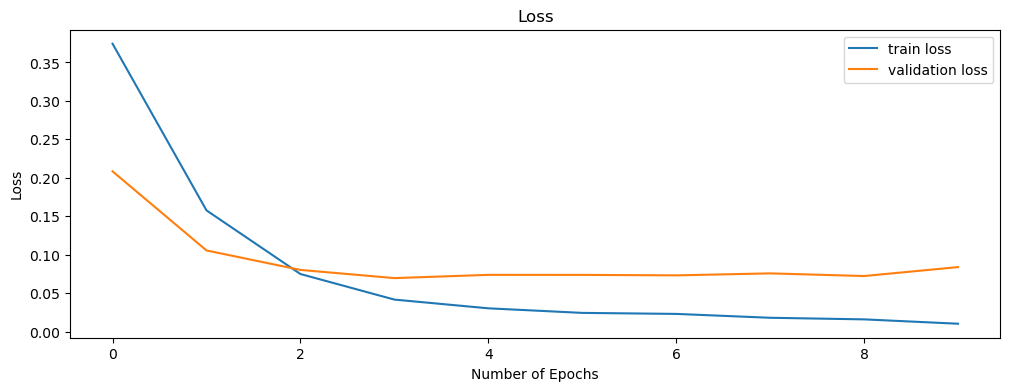

In [33]:
scores_df_spam = plot_loss(
    history_dense_simpler, 
    scores_df_spam, 
    'Embedding25_LSTM32_Dence128',
    accuracy,
)

In [34]:
scores_df_spam

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_RMSprop,0.006932,0.098520,0.986842
1,Embeddings25,0.009797,0.086750,0.986842
2,Embedding25_LSTM32,0.008170,0.094181,0.989234
3,Embedding25_LSTM32_Dence128,0.010284,0.083893,0.988038


In [35]:
reset_seeds()
inputs = Input(name='inputs',shape=[max_len]) 

layer = Embedding(
    max_words,
    25,
    input_length=max_len,
)(inputs) 
layer = LSTM(16)(layer) 
layer = Dense(64)(layer) 
layer = Activation('relu')(layer) 
layer = Dropout(0.5)(layer) 
layer = Dense(1,name='out_layer')(layer) 
layer = Activation('sigmoid')(layer) 

model_simple = Model(
    inputs=inputs,
    outputs=layer,
)

In [36]:
model_simple.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'],
)

history_simple = model_simple.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=10, 
    validation_split=0.2,
)

Epoch 1/10
30/30 [==============================] - 3s 42ms/step - loss: 0.4577 - accuracy: 0.8640 - val_loss: 0.2779 - val_accuracy: 0.8703
Epoch 2/10
30/30 [==============================] - 1s 32ms/step - loss: 0.2141 - accuracy: 0.9031 - val_loss: 0.1471 - val_accuracy: 0.9557
Epoch 3/10
30/30 [==============================] - 1s 33ms/step - loss: 0.1249 - accuracy: 0.9707 - val_loss: 0.1077 - val_accuracy: 0.9842
Epoch 4/10
30/30 [==============================] - 1s 38ms/step - loss: 0.0782 - accuracy: 0.9863 - val_loss: 0.0794 - val_accuracy: 0.9842
Epoch 5/10
30/30 [==============================] - 1s 33ms/step - loss: 0.0490 - accuracy: 0.9897 - val_loss: 0.0758 - val_accuracy: 0.9842
Epoch 6/10
30/30 [==============================] - 1s 33ms/step - loss: 0.0323 - accuracy: 0.9921 - val_loss: 0.0756 - val_accuracy: 0.9852
Epoch 7/10
30/30 [==============================] - 1s 32ms/step - loss: 0.0281 - accuracy: 0.9926 - val_loss: 0.0758 - val_accuracy: 0.9863
Epoch 8/10
30

In [37]:
accuracy = model_simple.evaluate(test_sequences_matrix,Y_test)[1]

27/27 [==============================] - 0s 6ms/step - loss: 0.0513 - accuracy: 0.9892


🎯 Train Loss: 0.01591597869992256
🎯 Val Loss: 0.07972799241542816


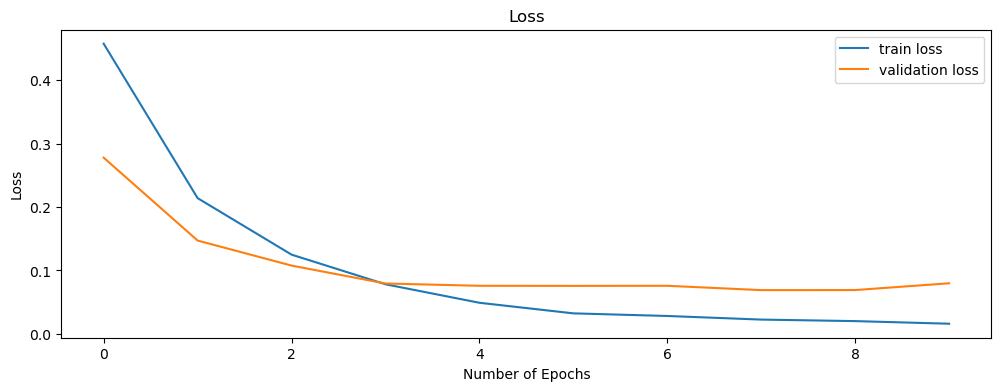

In [38]:
scores_df_spam = plot_loss(
    history_simple, 
    scores_df_spam, 
    'Embedding25_LSTM16_Dence64',
    accuracy,
)

In [39]:
scores_df_spam

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_RMSprop,0.006932,0.098520,0.986842
1,Embeddings25,0.009797,0.086750,0.986842
2,Embedding25_LSTM32,0.008170,0.094181,0.989234
3,Embedding25_LSTM32_Dence128,0.010284,0.083893,0.988038
4,Embedding25_LSTM16_Dence64,0.015916,0.079728,0.989234


In [40]:
reset_seeds()
inputs = Input(name='inputs',shape=[max_len]) 

layer = Embedding(
    max_words,
    25,
    input_length=max_len,
)(inputs) 
layer = LSTM(16)(layer) 
layer = Dense(32)(layer) 
layer = Activation('relu')(layer) 
layer = Dropout(0.5)(layer) 
layer = Dense(1,name='out_layer')(layer) 
layer = Activation('sigmoid')(layer) 

model_simpler = Model(
    inputs=inputs,
    outputs=layer,
)

In [41]:
model_simpler.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'],
)

history_simpler = model_simpler.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=10, 
    validation_split=0.2,
)

Epoch 1/10
30/30 [==============================] - 3s 42ms/step - loss: 0.4832 - accuracy: 0.8598 - val_loss: 0.3317 - val_accuracy: 0.8703
Epoch 2/10
30/30 [==============================] - 1s 32ms/step - loss: 0.2703 - accuracy: 0.8831 - val_loss: 0.1736 - val_accuracy: 0.9441
Epoch 3/10
30/30 [==============================] - 1s 32ms/step - loss: 0.1545 - accuracy: 0.9559 - val_loss: 0.1189 - val_accuracy: 0.9800
Epoch 4/10
30/30 [==============================] - 1s 31ms/step - loss: 0.1053 - accuracy: 0.9813 - val_loss: 0.0945 - val_accuracy: 0.9852
Epoch 5/10
30/30 [==============================] - 1s 31ms/step - loss: 0.0719 - accuracy: 0.9873 - val_loss: 0.0869 - val_accuracy: 0.9842
Epoch 6/10
30/30 [==============================] - 1s 31ms/step - loss: 0.0532 - accuracy: 0.9910 - val_loss: 0.0787 - val_accuracy: 0.9842
Epoch 7/10
30/30 [==============================] - 1s 33ms/step - loss: 0.0391 - accuracy: 0.9908 - val_loss: 0.0784 - val_accuracy: 0.9852
Epoch 8/10
30

In [42]:
accuracy = model_simpler.evaluate(test_sequences_matrix,Y_test)[1]

27/27 [==============================] - 0s 7ms/step - loss: 0.0495 - accuracy: 0.9904


🎯 Train Loss: 0.02021213248372078
🎯 Val Loss: 0.08492568880319595


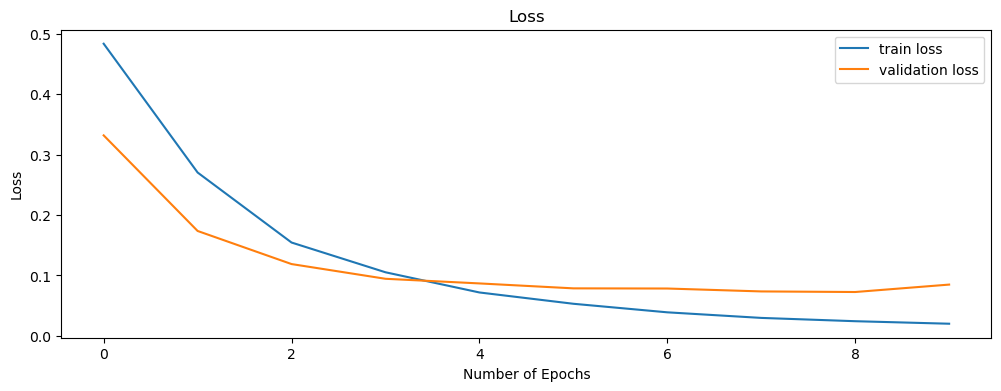

In [43]:
scores_df_spam = plot_loss(
    history_simpler, 
    scores_df_spam, 
    'Embedding25_LSTM16_Dence32',
    accuracy,
)

In [44]:
scores_df_spam

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_RMSprop,0.006932,0.098520,0.986842
1,Embeddings25,0.009797,0.086750,0.986842
2,Embedding25_LSTM32,0.008170,0.094181,0.989234
3,Embedding25_LSTM32_Dence128,0.010284,0.083893,0.988038
4,Embedding25_LSTM16_Dence64,0.015916,0.079728,0.989234
5,Embedding25_LSTM16_Dence32,0.020212,0.084926,0.990431


In [45]:
reset_seeds()
inputs = Input(name='inputs',shape=[max_len]) 

layer = Embedding(
    max_words,
    25,
    input_length=max_len,
)(inputs) 
layer = LSTM(8)(layer) 
layer = Dense(16)(layer) 
layer = Activation('relu')(layer) 
layer = Dropout(0.5)(layer) 
layer = Dense(1,name='out_layer')(layer) 
layer = Activation('sigmoid')(layer) 

model_simplest = Model(
    inputs=inputs,
    outputs=layer,
) 

In [46]:
model_simplest.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'],
)

history_simplest = model_simplest.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=10, 
    validation_split=0.2,
)

Epoch 1/10
30/30 [==============================] - 3s 40ms/step - loss: 0.5368 - accuracy: 0.8527 - val_loss: 0.3699 - val_accuracy: 0.8703
Epoch 2/10
30/30 [==============================] - 1s 30ms/step - loss: 0.3298 - accuracy: 0.8741 - val_loss: 0.2262 - val_accuracy: 0.9051
Epoch 3/10
30/30 [==============================] - 1s 31ms/step - loss: 0.2186 - accuracy: 0.9337 - val_loss: 0.1513 - val_accuracy: 0.9631
Epoch 4/10
30/30 [==============================] - 1s 31ms/step - loss: 0.1515 - accuracy: 0.9678 - val_loss: 0.1126 - val_accuracy: 0.9810
Epoch 5/10
30/30 [==============================] - 1s 30ms/step - loss: 0.1150 - accuracy: 0.9839 - val_loss: 0.0962 - val_accuracy: 0.9821
Epoch 6/10
30/30 [==============================] - 1s 30ms/step - loss: 0.0849 - accuracy: 0.9879 - val_loss: 0.0845 - val_accuracy: 0.9852
Epoch 7/10
30/30 [==============================] - 1s 30ms/step - loss: 0.0704 - accuracy: 0.9886 - val_loss: 0.0787 - val_accuracy: 0.9842
Epoch 8/10
30

In [47]:
accuracy = model_simplest.evaluate(test_sequences_matrix,Y_test)[1]

27/27 [==============================] - 0s 6ms/step - loss: 0.0585 - accuracy: 0.9892


🎯 Train Loss: 0.036597542464733124
🎯 Val Loss: 0.07893650978803635


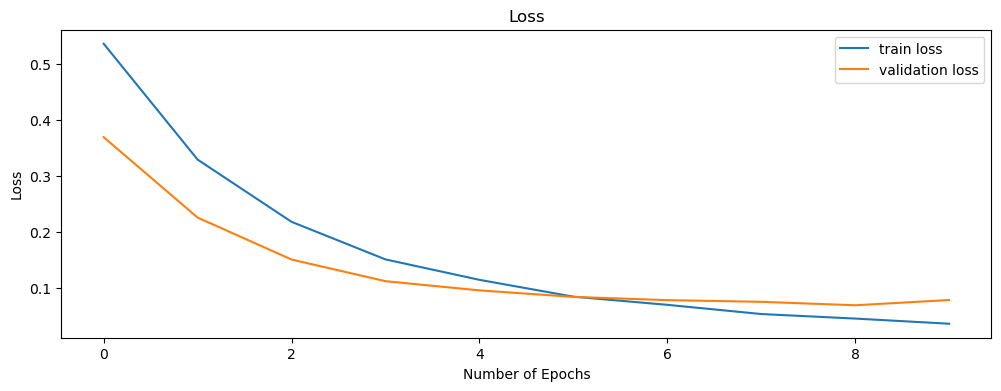

In [48]:
scores_df_spam = plot_loss(
    history_simplest, 
    scores_df_spam, 
    'Embedding25_LSTM8_Dence16',
    accuracy,
)

In [49]:
scores_df_spam

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_RMSprop,0.006932,0.098520,0.986842
1,Embeddings25,0.009797,0.086750,0.986842
2,Embedding25_LSTM32,0.008170,0.094181,0.989234
3,Embedding25_LSTM32_Dence128,0.010284,0.083893,0.988038
4,Embedding25_LSTM16_Dence64,0.015916,0.079728,0.989234
5,Embedding25_LSTM16_Dence32,0.020212,0.084926,0.990431
6,Embedding25_LSTM8_Dence16,0.036598,0.078937,0.989234


In [50]:
reset_seeds()
inputs = Input(name='inputs',shape=[max_len]) 

layer = Embedding(
    max_words,
    25,
    input_length=max_len,
)(inputs) 
layer = LSTM(16)(layer) 
layer = Dense(32)(layer) 
layer = Activation('relu')(layer) 
layer = Dropout(0.65)(layer) 
layer = Dense(1,name='out_layer')(layer) 
layer = Activation('sigmoid')(layer) 

model_simpler_dropout = Model(
    inputs=inputs,
    outputs=layer,
)

In [51]:
model_simpler_dropout.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'],
)

history_simpler_dropout = model_simpler_dropout.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=10, 
    validation_split=0.2,
)

Epoch 1/10
30/30 [==============================] - 3s 50ms/step - loss: 0.4978 - accuracy: 0.8559 - val_loss: 0.3299 - val_accuracy: 0.8703
Epoch 2/10
30/30 [==============================] - 1s 36ms/step - loss: 0.2872 - accuracy: 0.8823 - val_loss: 0.1817 - val_accuracy: 0.9451
Epoch 3/10
30/30 [==============================] - 1s 34ms/step - loss: 0.1706 - accuracy: 0.9520 - val_loss: 0.1225 - val_accuracy: 0.9778
Epoch 4/10
30/30 [==============================] - 1s 33ms/step - loss: 0.1165 - accuracy: 0.9805 - val_loss: 0.0984 - val_accuracy: 0.9852
Epoch 5/10
30/30 [==============================] - 1s 44ms/step - loss: 0.0844 - accuracy: 0.9857 - val_loss: 0.0903 - val_accuracy: 0.9852
Epoch 6/10
30/30 [==============================] - 1s 37ms/step - loss: 0.0623 - accuracy: 0.9889 - val_loss: 0.0880 - val_accuracy: 0.9863
Epoch 7/10
30/30 [==============================] - 1s 35ms/step - loss: 0.0480 - accuracy: 0.9902 - val_loss: 0.0792 - val_accuracy: 0.9831
Epoch 8/10
30

In [52]:
accuracy = model_simpler_dropout.evaluate(test_sequences_matrix, Y_test)[1]

27/27 [==============================] - 0s 7ms/step - loss: 0.0588 - accuracy: 0.9916


🎯 Train Loss: 0.025078268721699715
🎯 Val Loss: 0.09835474193096161


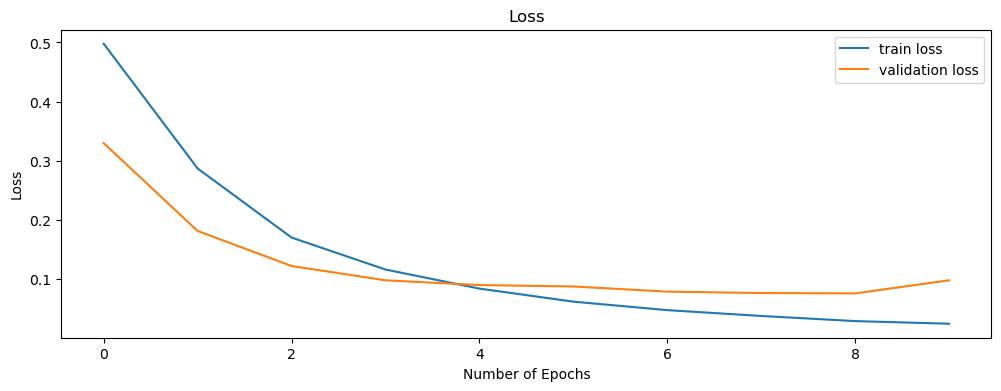

In [53]:
scores_df_spam = plot_loss(
    history_simpler_dropout, 
    scores_df_spam, 
    'Embedding25_LSTM16_Dence32_dropout',
    accuracy,
)

In [54]:
scores_df_spam

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_RMSprop,0.006932,0.098520,0.986842
1,Embeddings25,0.009797,0.086750,0.986842
2,Embedding25_LSTM32,0.008170,0.094181,0.989234
3,Embedding25_LSTM32_Dence128,0.010284,0.083893,0.988038
4,Embedding25_LSTM16_Dence64,0.015916,0.079728,0.989234
5,Embedding25_LSTM16_Dence32,0.020212,0.084926,0.990431
6,Embedding25_LSTM8_Dence16,0.036598,0.078937,0.989234
7,Embedding25_LSTM16_Dence32_dropout,0.025078,0.098355,0.991627


In [55]:
reset_seeds()
inputs = Input(name='inputs',shape=[max_len]) 

layer = Embedding(
    max_words,
    10,
    input_length=max_len,
)(inputs) 
layer = LSTM(8)(layer) 
layer = Dense(16)(layer) 
layer = Activation('relu')(layer) 
layer = Dropout(0.5)(layer) 
layer = Dense(1,name='out_layer')(layer) 
layer = Activation('sigmoid')(layer) 

model_short_embedding = Model(
    inputs=inputs,
    outputs=layer,
)

In [56]:
model_short_embedding.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'],
)

history_short_embedding = model_short_embedding.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=10, 
    validation_split=0.2,
)

Epoch 1/10
30/30 [==============================] - 3s 50ms/step - loss: 0.5422 - accuracy: 0.8622 - val_loss: 0.3859 - val_accuracy: 0.8703
Epoch 2/10
30/30 [==============================] - 1s 32ms/step - loss: 0.3695 - accuracy: 0.8691 - val_loss: 0.2797 - val_accuracy: 0.8703
Epoch 3/10
30/30 [==============================] - 1s 32ms/step - loss: 0.2669 - accuracy: 0.8854 - val_loss: 0.1857 - val_accuracy: 0.9230
Epoch 4/10
30/30 [==============================] - 1s 37ms/step - loss: 0.1873 - accuracy: 0.9477 - val_loss: 0.1362 - val_accuracy: 0.9726
Epoch 5/10
30/30 [==============================] - 1s 36ms/step - loss: 0.1434 - accuracy: 0.9731 - val_loss: 0.1135 - val_accuracy: 0.9768
Epoch 6/10
30/30 [==============================] - 1s 36ms/step - loss: 0.1085 - accuracy: 0.9810 - val_loss: 0.0920 - val_accuracy: 0.9810
Epoch 7/10
30/30 [==============================] - 1s 29ms/step - loss: 0.0884 - accuracy: 0.9855 - val_loss: 0.0852 - val_accuracy: 0.9821
Epoch 8/10
30

In [57]:
accuracy = model_short_embedding.evaluate(test_sequences_matrix, Y_test)[1]

27/27 [==============================] - 0s 6ms/step - loss: 0.0603 - accuracy: 0.9904


🎯 Train Loss: 0.046941399574279785
🎯 Val Loss: 0.07741891592741013


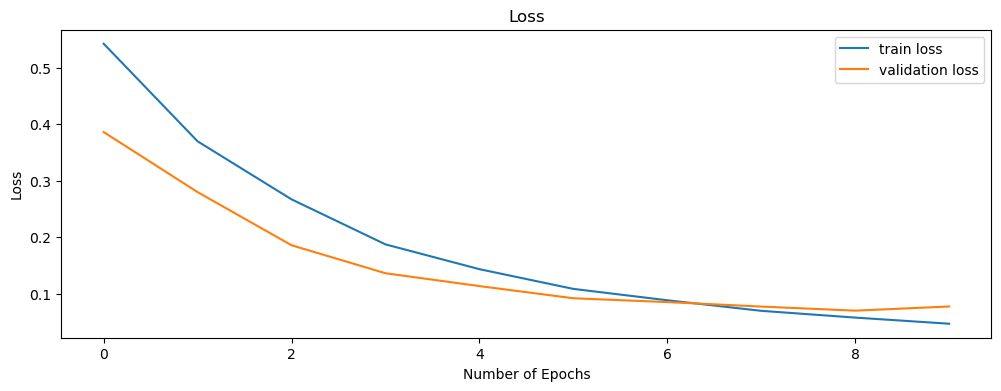

In [58]:
scores_df_spam = plot_loss(
    history_short_embedding,
    scores_df_spam, 
    'Embedding10_LSTM8_Dence16',
    accuracy,
)

In [59]:
scores_df_spam

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_RMSprop,0.006932,0.098520,0.986842
1,Embeddings25,0.009797,0.086750,0.986842
2,Embedding25_LSTM32,0.008170,0.094181,0.989234
3,Embedding25_LSTM32_Dence128,0.010284,0.083893,0.988038
4,Embedding25_LSTM16_Dence64,0.015916,0.079728,0.989234
5,Embedding25_LSTM16_Dence32,0.020212,0.084926,0.990431
6,Embedding25_LSTM8_Dence16,0.036598,0.078937,0.989234
7,Embedding25_LSTM16_Dence32_dropout,0.025078,0.098355,0.991627
8,Embedding10_LSTM8_Dence16,0.046941,0.077419,0.990431


In [60]:
reset_seeds()
inputs = Input(name='inputs',shape=[max_len]) 

layer = Embedding(
    max_words,
    10,
    input_length=max_len,
)(inputs) 
layer = LSTM(8)(layer) 
layer = Dense(16)(layer) 
layer = Activation('relu')(layer) 
layer = Dropout(0.65)(layer) 
layer = Dense(1,name='out_layer')(layer) 
layer = Activation('sigmoid')(layer) 

model_short_embedding_dropout = Model(
    inputs=inputs,
    outputs=layer,
)

In [61]:
model_short_embedding_dropout.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'],
)

history_short_embedding_dropout = model_short_embedding_dropout.fit(
    sequences_matrix,
    Y_train,
    batch_size=128,
    epochs=10, 
    validation_split=0.2,
)

Epoch 1/10
30/30 [==============================] - 3s 49ms/step - loss: 0.5513 - accuracy: 0.8630 - val_loss: 0.3915 - val_accuracy: 0.8703
Epoch 2/10
30/30 [==============================] - 1s 33ms/step - loss: 0.3957 - accuracy: 0.8691 - val_loss: 0.2865 - val_accuracy: 0.8703
Epoch 3/10
30/30 [==============================] - 1s 32ms/step - loss: 0.2949 - accuracy: 0.8809 - val_loss: 0.1933 - val_accuracy: 0.9156
Epoch 4/10
30/30 [==============================] - 1s 32ms/step - loss: 0.2124 - accuracy: 0.9327 - val_loss: 0.1434 - val_accuracy: 0.9705
Epoch 5/10
30/30 [==============================] - 1s 33ms/step - loss: 0.1693 - accuracy: 0.9654 - val_loss: 0.1203 - val_accuracy: 0.9747
Epoch 6/10
30/30 [==============================] - 1s 33ms/step - loss: 0.1384 - accuracy: 0.9760 - val_loss: 0.0973 - val_accuracy: 0.9810
Epoch 7/10
30/30 [==============================] - 1s 31ms/step - loss: 0.1124 - accuracy: 0.9815 - val_loss: 0.0906 - val_accuracy: 0.9810
Epoch 8/10
30

In [62]:
accuracy = model_short_embedding_dropout.evaluate(test_sequences_matrix, Y_test)[1]

27/27 [==============================] - 0s 6ms/step - loss: 0.0660 - accuracy: 0.9904


🎯 Train Loss: 0.07052036374807358
🎯 Val Loss: 0.0813877284526825


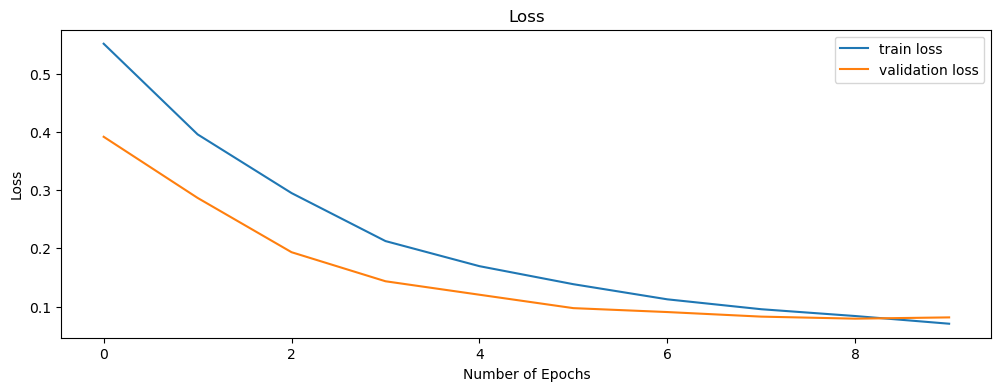

In [63]:
scores_df_spam = plot_loss(
    history_short_embedding_dropout,
    scores_df_spam, 
    'Embedding10_LSTM8_Dence16_dropout',
    accuracy,
)

<a name='13'></a>
## <span style="color:#ff5f27">📝 Results </span>
- [🗄️ Table of Contents](#0_0)

In [65]:
scores_df_spam

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_RMSprop,0.006932,0.098520,0.986842
1,Embeddings25,0.009797,0.086750,0.986842
2,Embedding25_LSTM32,0.008170,0.094181,0.989234
3,Embedding25_LSTM32_Dence128,0.010284,0.083893,0.988038
4,Embedding25_LSTM16_Dence64,0.015916,0.079728,0.989234
5,Embedding25_LSTM16_Dence32,0.020212,0.084926,0.990431
6,Embedding25_LSTM8_Dence16,0.036598,0.078937,0.989234
7,Embedding25_LSTM16_Dence32_dropout,0.025078,0.098355,0.991627
8,Embedding10_LSTM8_Dence16,0.046941,0.077419,0.990431
9,Embedding10_LSTM8_Dence16_dropout,0.070520,0.081388,0.990431


---
<a name='2'></a>
## <span style="color:#ff5f27">💾 IMDB Dataset </span>
- [🗄️ Table of Contents](#0_0)

In [50]:
from keras.datasets import imdb 
from keras.models import Sequential 
from tensorflow.keras.layers import BatchNormalization

In [51]:
top_words = 5000 

(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words) 

In [52]:
max_review_length = 500 

X_train = pad_sequences(X_train, maxlen=max_review_length) 
X_test = pad_sequences(X_test, maxlen=max_review_length) 

<a name='22'></a>
## <span style="color:#ff5f27">👩🏻‍🔬 Model Experiments </span>
- [🗄️ Table of Contents](#0_0)

In [53]:
scores_df_imdb = pd.DataFrame(columns=['model_name', 'train_loss', 'val_loss'])
scores_df_imdb

,model_name,train_loss,val_loss


In [54]:
# create the model 
embedding_vecor_length = 32 
reset_seeds()

model_default = Sequential() 
model_default.add(Embedding(
    top_words, 
    embedding_vecor_length, 
    input_length=max_review_length
)) 
model_default.add(LSTM(100)) 
model_default.add(Dense(1, activation='sigmoid')) 

model_default.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
) 
model_default.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 500, 32)           160000    
                                                                 
 lstm_7 (LSTM)               (None, 100)               53200     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________


In [55]:
history_default = model_default.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=3, 
    batch_size=64,
) 

Epoch 1/3
391/391 [==============================] - 126s 318ms/step - loss: 0.4700 - accuracy: 0.7650 - val_loss: 0.3280 - val_accuracy: 0.8636
Epoch 2/3
391/391 [==============================] - 150s 384ms/step - loss: 0.2879 - accuracy: 0.8832 - val_loss: 0.3034 - val_accuracy: 0.8700
Epoch 3/3
391/391 [==============================] - 155s 396ms/step - loss: 0.2416 - accuracy: 0.9084 - val_loss: 0.3094 - val_accuracy: 0.8704


In [56]:
scores = model_default.evaluate(X_test, y_test, verbose=0)[1]*100

🎯 Train Loss: 0.24157147109508514
🎯 Val Loss: 0.3094145953655243


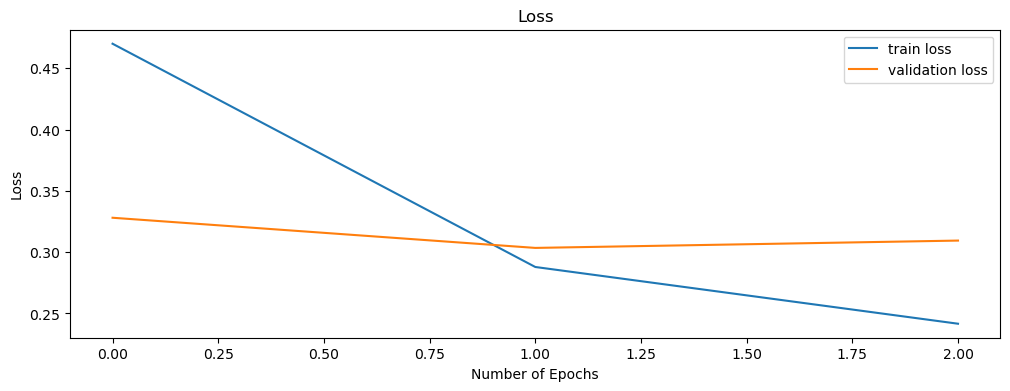

In [57]:
scores_df_imdb = plot_loss(
    history_default, 
    scores_df_imdb, 
    'LSTM_Default',
    scores,
)

In [58]:
reset_seeds()
model_dropout = Sequential() 
model_dropout.add(Embedding(
    top_words, 
    embedding_vecor_length, 
    input_length=max_review_length,
)) 
model_dropout.add(Dropout(0.2)) 
model_dropout.add(LSTM(100)) 
model_dropout.add(Dropout(0.2)) 
model_dropout.add(Dense(1, activation='sigmoid')) 

In [59]:
model_dropout.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
) 

In [60]:
history_dropout = model_dropout.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test),
    epochs=3, 
    batch_size=64,
) 

Epoch 1/3
391/391 [==============================] - 149s 378ms/step - loss: 0.4862 - accuracy: 0.7572 - val_loss: 0.3671 - val_accuracy: 0.8405
Epoch 2/3
391/391 [==============================] - 145s 371ms/step - loss: 0.3075 - accuracy: 0.8760 - val_loss: 0.3086 - val_accuracy: 0.8768
Epoch 3/3
391/391 [==============================] - 156s 398ms/step - loss: 0.2408 - accuracy: 0.9071 - val_loss: 0.2997 - val_accuracy: 0.8748


In [61]:
scores = model_dropout.evaluate(X_test, y_test, verbose=0)[1]*100

🎯 Train Loss: 0.2408207356929779
🎯 Val Loss: 0.2997487485408783


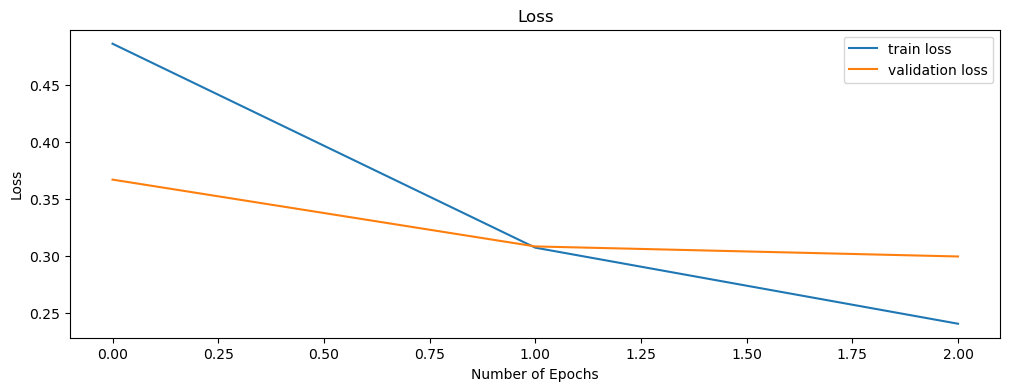

In [62]:
scores_df_imdb = plot_loss(
    history_dropout, 
    scores_df_imdb, 
    'LSTM_Dropout', 
    scores,
)

In [63]:
scores_df_imdb

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_Default,0.241571,0.309415,87.044001
1,LSTM_Dropout,0.240821,0.299749,87.475997


In [64]:
embedding_vecor_length = 32 
reset_seeds()

model_inner_dropout = Sequential() 
model_inner_dropout.add(Embedding(
    top_words, 
    embedding_vecor_length, 
    input_length=max_review_length,
)) 
model_inner_dropout.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) 
model_inner_dropout.add(Dense(1, activation='sigmoid')) 

model_inner_dropout.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
) 

In [65]:
history_inner_dropout = model_inner_dropout.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=3, 
    batch_size=64,
) 

Epoch 1/3
391/391 [==============================] - 225s 571ms/step - loss: 0.4967 - accuracy: 0.7610 - val_loss: 0.4637 - val_accuracy: 0.7888
Epoch 2/3
391/391 [==============================] - 213s 546ms/step - loss: 0.3567 - accuracy: 0.8548 - val_loss: 0.3674 - val_accuracy: 0.8418
Epoch 3/3
391/391 [==============================] - 224s 574ms/step - loss: 0.3142 - accuracy: 0.8732 - val_loss: 0.3647 - val_accuracy: 0.8490


In [66]:
scores = model_inner_dropout.evaluate(X_test, y_test, verbose=0)[1]*100

🎯 Train Loss: 0.31416982412338257
🎯 Val Loss: 0.3647339940071106


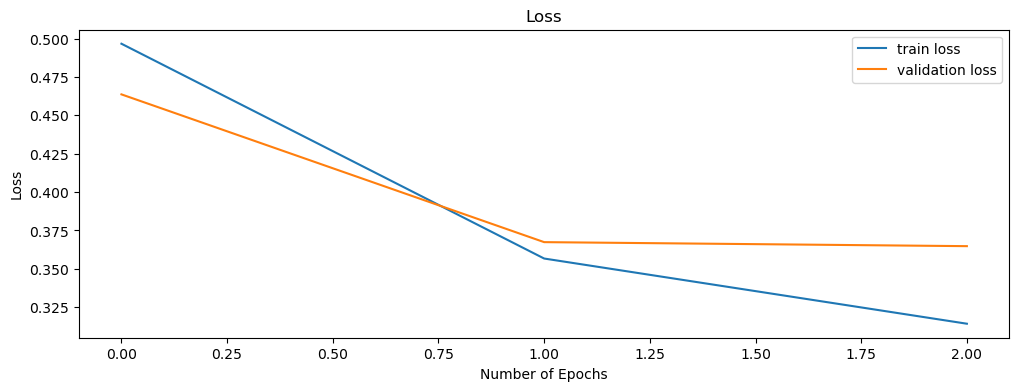

In [67]:
scores_df_imdb = plot_loss(
    history_inner_dropout, 
    scores_df_imdb, 
    'LSTM_inner_Dropout',
    scores,
)

In [68]:
scores_df_imdb

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_Default,0.241571,0.309415,87.044001
1,LSTM_Dropout,0.240821,0.299749,87.475997
2,LSTM_inner_Dropout,0.31417,0.364734,84.899998


In [69]:
reset_seeds()
model_simpler_lstm = Sequential() 
model_simpler_lstm.add(Embedding(
    top_words, 
    embedding_vecor_length,
    input_length=max_review_length,
)) 
model_simpler_lstm.add(LSTM(32, dropout=0.1, recurrent_dropout=0.1)) # return_sequences=True,
model_simpler_lstm.add(Dropout(0.4))
model_simpler_lstm.add(Dense(1, activation='sigmoid')) 

model_simpler_lstm.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
)

In [70]:
history_simpler_lstm = model_simpler_lstm.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=3, 
    batch_size=64,
) 

Epoch 1/3
391/391 [==============================] - 124s 313ms/step - loss: 0.4670 - accuracy: 0.7774 - val_loss: 0.3286 - val_accuracy: 0.8629
Epoch 2/3
391/391 [==============================] - 130s 332ms/step - loss: 0.2973 - accuracy: 0.8843 - val_loss: 0.3083 - val_accuracy: 0.8718
Epoch 3/3
391/391 [==============================] - 121s 308ms/step - loss: 0.2456 - accuracy: 0.9080 - val_loss: 0.3177 - val_accuracy: 0.8683


In [71]:
scores = model_simpler_lstm.evaluate(X_test, y_test, verbose=0)[1]*100

🎯 Train Loss: 0.24564576148986816
🎯 Val Loss: 0.3177192807197571


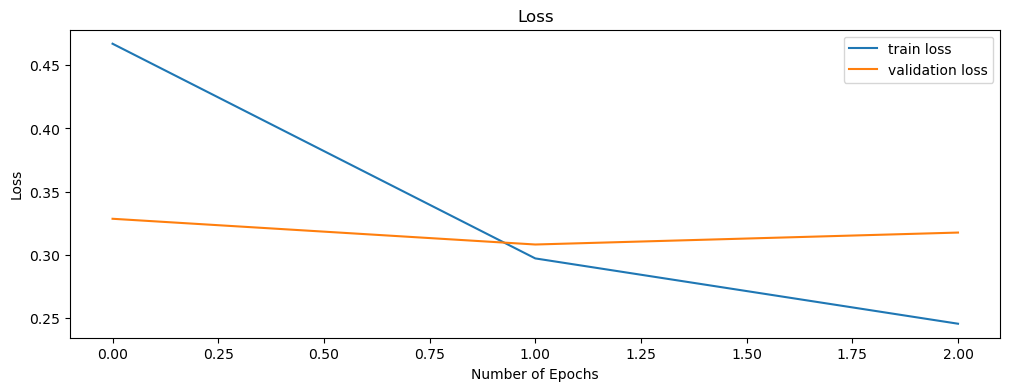

In [72]:
scores_df_imdb = plot_loss(
    history_simpler_lstm, 
    scores_df_imdb, 
    'Simpler_LSTM',
    scores,
)

In [73]:
scores_df_imdb

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_Default,0.241571,0.309415,87.044001
1,LSTM_Dropout,0.240821,0.299749,87.475997
2,LSTM_inner_Dropout,0.31417,0.364734,84.899998
3,Simpler_LSTM,0.245646,0.317719,86.827999


In [74]:
reset_seeds()
model_simple_lstm_bn = Sequential() 
model_simple_lstm_bn.add(Embedding(
    top_words, 
    embedding_vecor_length, 
    input_length=max_review_length,
)) 
model_simple_lstm_bn.add(LSTM(64)) 
model_simple_lstm_bn.add(BatchNormalization())
model_simple_lstm_bn.add(Dense(1, activation='sigmoid')) 

model_simple_lstm_bn.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
)

In [75]:
history_simple_lstm_bn = model_simple_lstm_bn.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=3, 
    batch_size=64,
) 

Epoch 1/3
391/391 [==============================] - 98s 246ms/step - loss: 0.4016 - accuracy: 0.8096 - val_loss: 0.3901 - val_accuracy: 0.8552
Epoch 2/3
391/391 [==============================] - 97s 248ms/step - loss: 0.2538 - accuracy: 0.8978 - val_loss: 0.3033 - val_accuracy: 0.8697
Epoch 3/3
391/391 [==============================] - 100s 257ms/step - loss: 0.2130 - accuracy: 0.9159 - val_loss: 0.3195 - val_accuracy: 0.8665


In [76]:
scores = model_simple_lstm_bn.evaluate(X_test, y_test, verbose=0)[1]*100

🎯 Train Loss: 0.2130175530910492
🎯 Val Loss: 0.3195159435272217


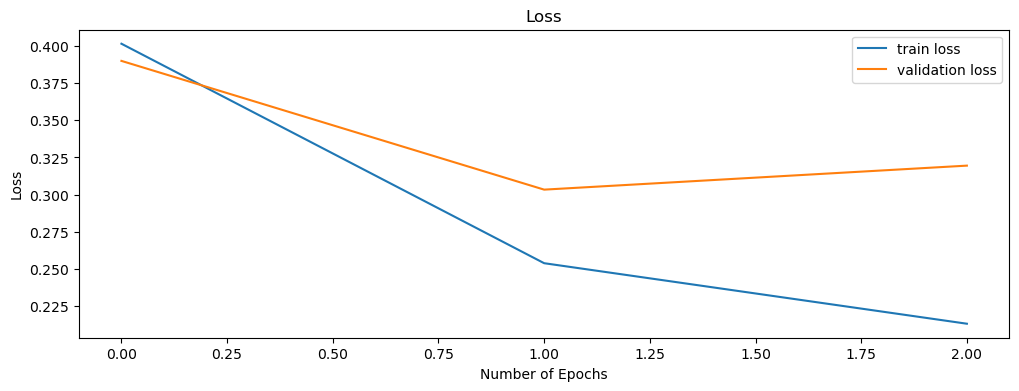

In [77]:
scores_df_imdb = plot_loss(
    history_simple_lstm_bn, 
    scores_df_imdb, 
    'Simple_LSTM_BatchNormalization',
    scores,
)

In [78]:
scores_df_imdb

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_Default,0.241571,0.309415,87.044001
1,LSTM_Dropout,0.240821,0.299749,87.475997
2,LSTM_inner_Dropout,0.31417,0.364734,84.899998
3,Simpler_LSTM,0.245646,0.317719,86.827999
4,Simple_LSTM_BatchNormalization,0.213018,0.319516,86.647999


In [79]:
reset_seeds()
model_simpler_lstm_dropout = Sequential() 
model_simpler_lstm_dropout.add(Embedding(
    top_words, 
    embedding_vecor_length,
    input_length=max_review_length,
)) 
model_simpler_lstm_dropout.add(LSTM(32, dropout=0.25, recurrent_dropout=0.25))
model_simpler_lstm_dropout.add(Dropout(0.5))
model_simpler_lstm_dropout.add(Dense(1, activation='sigmoid')) 

model_simpler_lstm_dropout.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
)

In [80]:
history_simpler_lstm_dropout = model_simpler_lstm_dropout.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=3, 
    batch_size=64,
) 

Epoch 1/3
391/391 [==============================] - 135s 339ms/step - loss: 0.4735 - accuracy: 0.7716 - val_loss: 0.3188 - val_accuracy: 0.8675
Epoch 2/3
391/391 [==============================] - 135s 346ms/step - loss: 0.2959 - accuracy: 0.8855 - val_loss: 0.5018 - val_accuracy: 0.8441
Epoch 3/3
391/391 [==============================] - 145s 371ms/step - loss: 0.4221 - accuracy: 0.7944 - val_loss: 0.4227 - val_accuracy: 0.8026


In [81]:
scores = model_simpler_lstm_dropout.evaluate(X_test, y_test, verbose=0)[1]*100

🎯 Train Loss: 0.42212244868278503
🎯 Val Loss: 0.4226652681827545


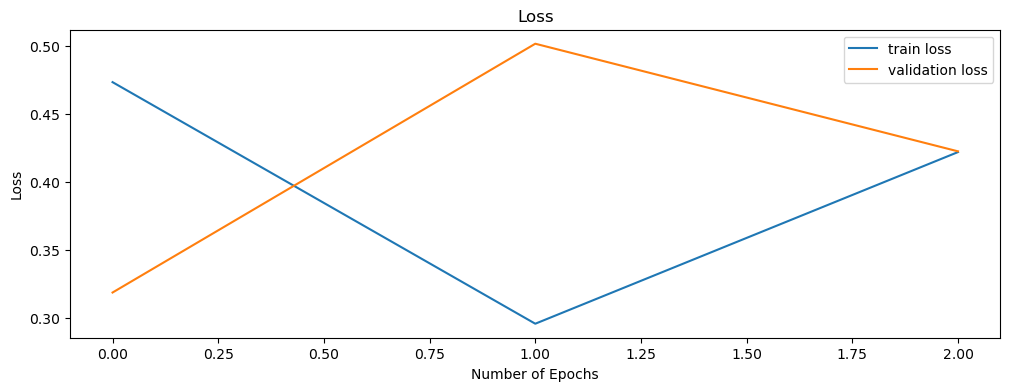

In [82]:
scores_df_imdb = plot_loss(
    history_simpler_lstm_dropout, 
    scores_df_imdb, 
    'Simple_LSTM_More_Dropout',
    scores,
)

In [83]:
scores_df_imdb

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_Default,0.241571,0.309415,87.044001
1,LSTM_Dropout,0.240821,0.299749,87.475997
2,LSTM_inner_Dropout,0.31417,0.364734,84.899998
3,Simpler_LSTM,0.245646,0.317719,86.827999
4,Simple_LSTM_BatchNormalization,0.213018,0.319516,86.647999
5,Simple_LSTM_More_Dropout,0.422122,0.422665,80.264002


<a name='23'></a>
## <span style="color:#ff5f27">👮🏻‍♂️ Final Model Validation </span>
- [🗄️ Table of Contents](#0_0)


In [84]:
# Final evaluation of the model 
best_lstm_score = model_simpler_lstm.evaluate(X_test, y_test, verbose=0)[1]*100 
print("🚀 Final Model Accuracy: %.2f%%" % (best_lstm_score)) 

🚀 Final Model Accuracy: 86.83%


<a name='24'></a>
## <span style="color:#ff5f27">👩🏻‍🔬 LSTM+CNN Architecture </span>
- [🗄️ Table of Contents](#0_0)


In [85]:
reset_seeds()
embedding_vecor_length = 32 
model_lstm_conv = Sequential() 
model_lstm_conv.add(Embedding(
    top_words, 
    embedding_vecor_length, 
    input_length=max_review_length,
)) 
model_lstm_conv.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')) 
model_lstm_conv.add(MaxPooling1D(pool_size=2)) 
model_lstm_conv.add(LSTM(100)) 
model_lstm_conv.add(Dense(1, activation='sigmoid'))

model_lstm_conv.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
)

In [86]:
history_lstm_conv = model_lstm_conv.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=3, 
    batch_size=64,
) 

Epoch 1/3
391/391 [==============================] - 102s 255ms/step - loss: 0.4652 - accuracy: 0.7609 - val_loss: 0.3110 - val_accuracy: 0.8662
Epoch 2/3
391/391 [==============================] - 98s 250ms/step - loss: 0.2433 - accuracy: 0.9041 - val_loss: 0.2761 - val_accuracy: 0.8864
Epoch 3/3
391/391 [==============================] - 98s 250ms/step - loss: 0.2039 - accuracy: 0.9225 - val_loss: 0.2847 - val_accuracy: 0.8815


In [87]:
scores = model_lstm_conv.evaluate(X_test, y_test, verbose=0)[1]*100

🎯 Train Loss: 0.20387908816337585
🎯 Val Loss: 0.2846883535385132


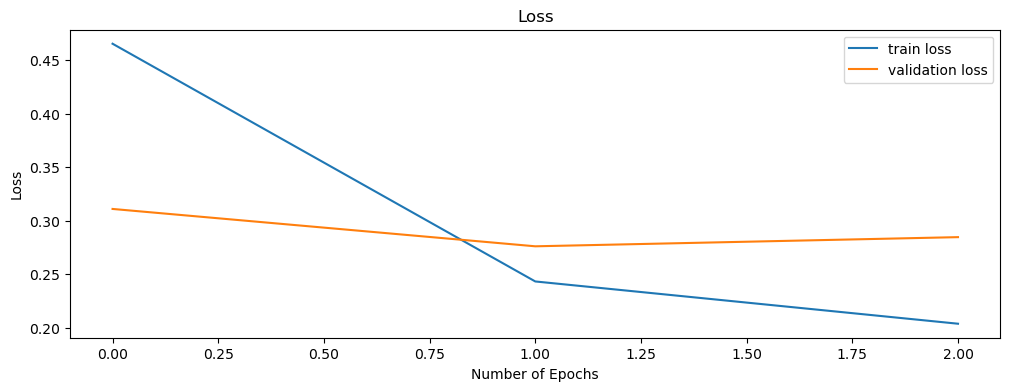

In [88]:
scores_df_imdb = plot_loss(
    history_lstm_conv,
    scores_df_imdb, 
    'LSTM_Conv',
    scores,
)

In [89]:
scores_df_imdb

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_Default,0.241571,0.309415,87.044001
1,LSTM_Dropout,0.240821,0.299749,87.475997
2,LSTM_inner_Dropout,0.31417,0.364734,84.899998
3,Simpler_LSTM,0.245646,0.317719,86.827999
4,Simple_LSTM_BatchNormalization,0.213018,0.319516,86.647999
5,Simple_LSTM_More_Dropout,0.422122,0.422665,80.264002
6,LSTM_Conv,0.203879,0.284688,88.147998


In [90]:
reset_seeds()
model_lstm_conv_simpler = Sequential() 
model_lstm_conv_simpler.add(Embedding(
    top_words, 
    embedding_vecor_length, 
    input_length=max_review_length,
)) 
model_lstm_conv_simpler.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')) 
model_lstm_conv_simpler.add(MaxPooling1D(pool_size=2))
model_lstm_conv_simpler.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2)) # return_sequences=True
model_lstm_conv_simpler.add(Dropout(0.2))
model_lstm_conv_simpler.add(Dense(1, activation='sigmoid'))

model_lstm_conv_simpler.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
)

In [91]:
history_lstm_conv_simpler = model_lstm_conv_simpler.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=3, 
    batch_size=64,
) 

Epoch 1/3
391/391 [==============================] - 97s 242ms/step - loss: 0.4339 - accuracy: 0.7804 - val_loss: 0.3211 - val_accuracy: 0.8650
Epoch 2/3
391/391 [==============================] - 91s 233ms/step - loss: 0.2432 - accuracy: 0.9049 - val_loss: 0.2877 - val_accuracy: 0.8804
Epoch 3/3
391/391 [==============================] - 75s 193ms/step - loss: 0.2107 - accuracy: 0.9197 - val_loss: 0.2962 - val_accuracy: 0.8756


In [92]:
scores = model_lstm_conv_simpler.evaluate(X_test, y_test, verbose=0)[1]*100

🎯 Train Loss: 0.2106991559267044
🎯 Val Loss: 0.2962418496608734


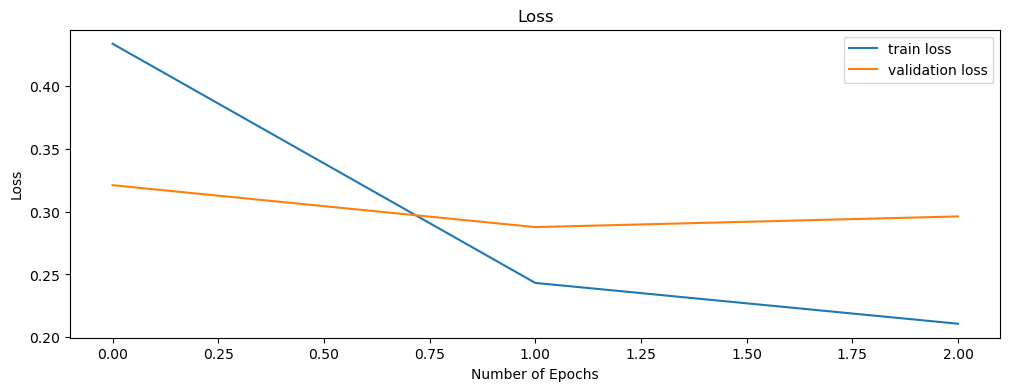

In [93]:
scores_df_imdb = plot_loss(
    history_lstm_conv_simpler,
    scores_df_imdb, 
    'LSTM_Conv_Simpler',
    scores,
)

In [94]:
reset_seeds()
model_lstm_conv_simpler_dropout = Sequential() 
model_lstm_conv_simpler_dropout.add(Embedding(
    top_words, 
    embedding_vecor_length, 
    input_length=max_review_length,
)) 
model_lstm_conv_simpler_dropout.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')) 
model_lstm_conv_simpler_dropout.add(MaxPooling1D(pool_size=2))
model_lstm_conv_simpler_dropout.add(Dropout(0.25))
model_lstm_conv_simpler_dropout.add(LSTM(64, dropout=0.35, recurrent_dropout=0.35)) # return_sequences=True
model_lstm_conv_simpler_dropout.add(Dropout(0.35))
model_lstm_conv_simpler_dropout.add(Dense(1, activation='sigmoid'))

model_lstm_conv_simpler_dropout.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
)

In [95]:
history_lstm_conv_simpler_dropout = model_lstm_conv_simpler_dropout.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=3, 
    batch_size=64,
) 

Epoch 1/3
391/391 [==============================] - 78s 195ms/step - loss: 0.4659 - accuracy: 0.7591 - val_loss: 0.2888 - val_accuracy: 0.8806
Epoch 2/3
391/391 [==============================] - 76s 194ms/step - loss: 0.2641 - accuracy: 0.8966 - val_loss: 0.2781 - val_accuracy: 0.8872
Epoch 3/3
391/391 [==============================] - 80s 205ms/step - loss: 0.2237 - accuracy: 0.9144 - val_loss: 0.2847 - val_accuracy: 0.8836


In [96]:
scores = model_lstm_conv_simpler_dropout.evaluate(X_test, y_test, verbose=0)[1]*100

🎯 Train Loss: 0.2237255871295929
🎯 Val Loss: 0.2847074568271637


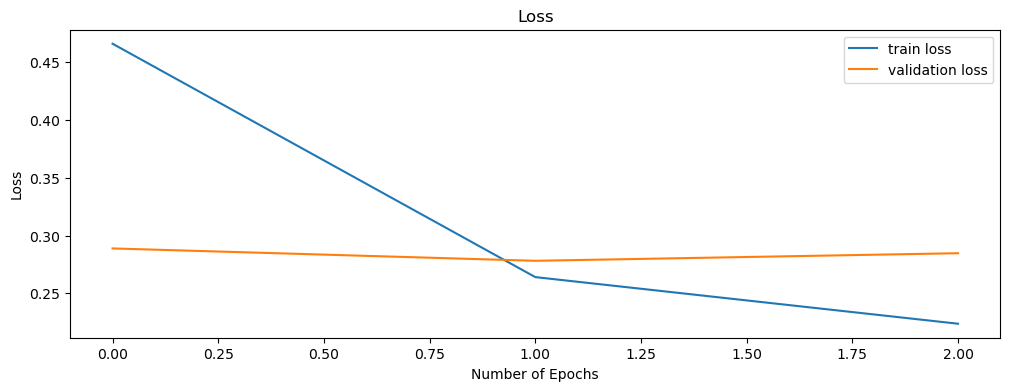

In [97]:
scores_df_imdb = plot_loss(
    history_lstm_conv_simpler_dropout,
    scores_df_imdb, 
    'LSTM_Conv_Simpler_Dropout',
    scores,
)

In [98]:
scores_df_imdb

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_Default,0.241571,0.309415,87.044001
1,LSTM_Dropout,0.240821,0.299749,87.475997
2,LSTM_inner_Dropout,0.31417,0.364734,84.899998
3,Simpler_LSTM,0.245646,0.317719,86.827999
4,Simple_LSTM_BatchNormalization,0.213018,0.319516,86.647999
5,Simple_LSTM_More_Dropout,0.422122,0.422665,80.264002
6,LSTM_Conv,0.203879,0.284688,88.147998
7,LSTM_Conv_Simpler,0.210699,0.296242,87.559998
8,LSTM_Conv_Simpler_Dropout,0.223726,0.284707,88.356000


In [100]:
reset_seeds()
model_lstm_conv_simpler_more_dropout = Sequential() 
model_lstm_conv_simpler_more_dropout.add(Embedding(
    top_words, 
    embedding_vecor_length, 
    input_length=max_review_length,
)) 
model_lstm_conv_simpler_more_dropout.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')) 
model_lstm_conv_simpler_more_dropout.add(MaxPooling1D(pool_size=2))
model_lstm_conv_simpler_more_dropout.add(Dropout(0.35))
model_lstm_conv_simpler_more_dropout.add(LSTM(32, dropout=0.4, recurrent_dropout=0.4)) # return_sequences=True
model_lstm_conv_simpler_more_dropout.add(Dropout(0.45))
model_lstm_conv_simpler_more_dropout.add(Dense(1, activation='sigmoid'))

model_lstm_conv_simpler_more_dropout.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
)

In [101]:
history_lstm_conv_simpler_more_dropout = model_lstm_conv_simpler_more_dropout.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=3, 
    batch_size=64,
) 

Epoch 1/3
391/391 [==============================] - 89s 221ms/step - loss: 0.4795 - accuracy: 0.7429 - val_loss: 0.3609 - val_accuracy: 0.8425
Epoch 2/3
391/391 [==============================] - 79s 203ms/step - loss: 0.2753 - accuracy: 0.8929 - val_loss: 0.2878 - val_accuracy: 0.8844
Epoch 3/3
391/391 [==============================] - 79s 203ms/step - loss: 0.2258 - accuracy: 0.9148 - val_loss: 0.2839 - val_accuracy: 0.8826


In [102]:
scores = model_lstm_conv_simpler_more_dropout.evaluate(X_test, y_test, verbose=0)[1]*100

🎯 Train Loss: 0.22582341730594635
🎯 Val Loss: 0.2839307487010956


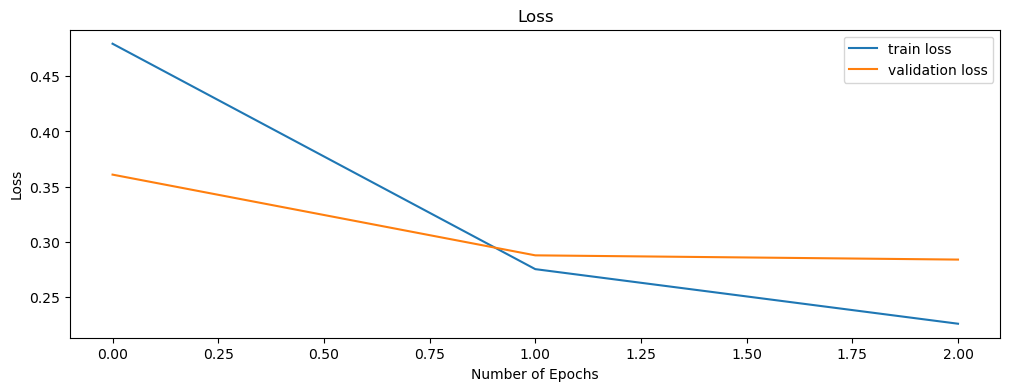

In [103]:
scores_df_imdb = plot_loss(
    history_lstm_conv_simpler_more_dropout,
    scores_df_imdb, 
    'LSTM_Conv_Simpler_More_Dropout',
    scores,
)

In [104]:
scores_df_imdb

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_Default,0.241571,0.309415,87.044001
1,LSTM_Dropout,0.240821,0.299749,87.475997
2,LSTM_inner_Dropout,0.31417,0.364734,84.899998
3,Simpler_LSTM,0.245646,0.317719,86.827999
4,Simple_LSTM_BatchNormalization,0.213018,0.319516,86.647999
5,Simple_LSTM_More_Dropout,0.422122,0.422665,80.264002
6,LSTM_Conv,0.203879,0.284688,88.147998
7,LSTM_Conv_Simpler,0.210699,0.296242,87.559998
8,LSTM_Conv_Simpler_Dropout,0.223726,0.284707,88.356000
9,LSTM_Conv_Simpler_More_Dropout,0.225823,0.283931,88.260001


In [105]:
reset_seeds()
model_lstm_conv_more_simpler_more_dropout = Sequential() 
model_lstm_conv_more_simpler_more_dropout.add(Embedding(
    top_words, 
    embedding_vecor_length, 
    input_length=max_review_length,
)) 
model_lstm_conv_more_simpler_more_dropout.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')) 
model_lstm_conv_more_simpler_more_dropout.add(MaxPooling1D(pool_size=2))
model_lstm_conv_more_simpler_more_dropout.add(Dropout(0.4))
model_lstm_conv_more_simpler_more_dropout.add(LSTM(32, dropout=0.4, recurrent_dropout=0.4)) # return_sequences=True
model_lstm_conv_more_simpler_more_dropout.add(Dropout(0.5))
model_lstm_conv_more_simpler_more_dropout.add(Dense(1, activation='sigmoid'))

model_lstm_conv_more_simpler_more_dropout.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'],
)

In [106]:
history_lstm_conv_more_simpler_more_dropout = model_lstm_conv_more_simpler_more_dropout.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test), 
    epochs=3, 
    batch_size=64,
) 

Epoch 1/3
391/391 [==============================] - 83s 207ms/step - loss: 0.4760 - accuracy: 0.7570 - val_loss: 0.2940 - val_accuracy: 0.8774
Epoch 2/3
391/391 [==============================] - 71s 181ms/step - loss: 0.2796 - accuracy: 0.8924 - val_loss: 0.2727 - val_accuracy: 0.8864
Epoch 3/3
391/391 [==============================] - 69s 177ms/step - loss: 0.2303 - accuracy: 0.9140 - val_loss: 0.2768 - val_accuracy: 0.8857


In [107]:
scores = model_lstm_conv_more_simpler_more_dropout.evaluate(X_test, y_test, verbose=0)[1]*100

🎯 Train Loss: 0.2303043007850647
🎯 Val Loss: 0.2768230736255646


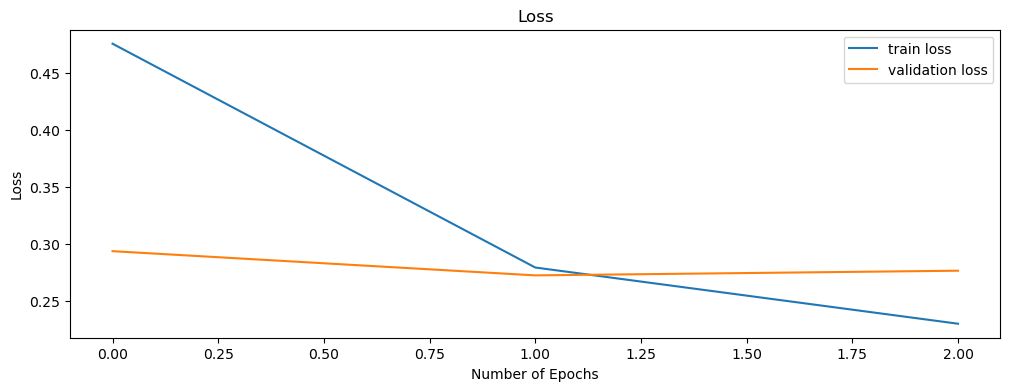

In [108]:
scores_df_imdb = plot_loss(
    history_lstm_conv_more_simpler_more_dropout,
    scores_df_imdb, 
    'LSTM_Conv_More_Simpler_More_Dropout',
    scores,
)

<a name='25'></a>
## <span style="color:#ff5f27">📝 Results </span>
- [🗄️ Table of Contents](#0_0)

In [111]:
scores_df_imdb

,model_name,train_loss,val_loss,test_accuracy
0,LSTM_Default,0.241571,0.309415,87.044001
1,LSTM_Dropout,0.240821,0.299749,87.475997
2,LSTM_inner_Dropout,0.31417,0.364734,84.899998
3,Simpler_LSTM,0.245646,0.317719,86.827999
4,Simple_LSTM_BatchNormalization,0.213018,0.319516,86.647999
5,Simple_LSTM_More_Dropout,0.422122,0.422665,80.264002
6,LSTM_Conv,0.203879,0.284688,88.147998
7,LSTM_Conv_Simpler,0.210699,0.296242,87.559998
8,LSTM_Conv_Simpler_Dropout,0.223726,0.284707,88.356000
9,LSTM_Conv_Simpler_More_Dropout,0.225823,0.283931,88.260001


- [🗄️ Table of Contents](#0_0)

---